# Hanes Brand Predictive Maintenance

In this notebook, we will explore various methods to handle the imbalance between the number of failures compared to non-failures.  In addition, we will attempt to fit various classification methods to the data in hopes of successsfully predicting a failure before it happens.

## Customize Enviornment

In [2]:
# load packages
packages <- c("purrr", "doMC", "RMySQL", "lubridate", "ggplot2", "caret", "DMwR", "ROSE", "e1071", "randomForest", 
              "party", "Matrix", "xgboost", "DiagrammeR", "ipred", "nnet", "pROC")
purrr::walk(packages, library, character.only = TRUE, warn.conflicts = FALSE)

# set default plot size
options(repr.plot.width=10, repr.plot.height=6)

# configure multicore processing
registerDoMC(cores=8)

## Load Data

In [12]:
# create an open connection to the database
#cn <- dbConnect(drv = RMySQL::MySQL(),
#                host = "130.39.81.34",
#                port = 3306,
#                user = "champt9",
#                password = "champt9",
#                dbname = "hanes")

# query the database and store the results into a DataFrame
#df <- dbGetQuery(cn, "SELECT * FROM dryer3_1_hour_before_down")
#dbDisconnect(cn)

[1] TRUE

In [3]:
# save df to local machine
#saveRDS(df, "dryer3_1_hour_before_down.Rda")
df <- readRDS("dryer3_1_hour_before_down.Rda")

In [4]:
# show a sample of the data
head(df)

Datetime_hour,DOWN,CircFan1_max,CircFan1_mean,CircFan1_min,CircFan1_std,CircFan2_max,CircFan2_mean,CircFan2_min,CircFan2_std,⋯,Valve4_min,Valve4_std,Valve5_max,Valve5_mean,Valve5_min,Valve5_std,Valve6_max,Valve6_mean,Valve6_min,Valve6_std
2015-01-01 00:00:00,0,100,100,100,0,100,100,100,0,⋯,100,0.000000,100,100.0,100,0.000000,100,100,100,0
2015-01-01 01:00:00,0,100,100,100,0,100,100,100,0,⋯,98,0.461133,100,100.0,100,0.000000,100,100,100,0
2015-01-01 02:00:00,0,100,100,100,0,100,100,100,0,⋯,81,4.944404,100,99.5,91,1.943158,100,100,100,0
2015-01-01 03:00:00,0,100,100,100,0,100,100,100,0,⋯,94,1.381736,100,100.0,100,0.000000,100,100,100,0
2015-01-01 04:00:00,0,100,100,100,0,100,100,100,0,⋯,92,1.695498,100,100.0,100,0.000000,100,100,100,0
2015-01-01 05:00:00,0,100,100,100,0,100,100,100,0,⋯,100,0.000000,100,100.0,100,0.000000,100,100,100,0


## Feature Engineering

### Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. Feature engineering is fundamental to the application of machine learning, and is both difficult and expensive.

In [5]:
# create a new variable that indicates failure in the next hour
df$Class  <- as.factor(df$DOWN)

# drop the old failure indicators
df$DOWN <- NULL

# create variable names for the Class variable
levels(df$Class) <- make.names(c("notDown", "down"))

In [6]:
# create new variables for dates and time
df$Datetime_hour <- ymd_hms(df$Datetime)
df$Year <- year(df$Datetime_hour)
df$Month <- month(df$Datetime_hour)
df$Day <- day(df$Datetime_hour)
df$Hour <- hour(df$Datetime_hour)
df$Minute <- minute(df$Datetime_hour)
df$Datetime_hour <- NULL

## Review Proportion of Downtime

### Before we get into looking at the class imbalance, let's look at what months we have data from.  We will also look at how many downtimes happened in each of those months

In [7]:
# look at the number of records per month
cat("Number of events per month:")
table(df$Year, df$Month)

# look at the number of failures per month
cat("\nNumber of downtimes per month:")
down <- df[df$Class == 'down', ]
table(down$Year, down$Month)

Number of events per month:

      
         1   2   3   4   5   6   7   8   9  10  11  12
  2015 701 409 713 697 671 641 687 672 603 501 560 465
  2016 419 272 507 611 613 544   0   0   0   0   0   0


Number of downtimes per month:

      
        1  2  3  4  5  6  7  8  9 10 11 12
  2015 24 11 24 16 24 28 25 27 25 18 29 29
  2016 21  9 26 24 17 19  0  0  0  0  0  0

#### As we can see in the number of downtimes per month is relatively consistent.  

In [8]:
# subset df to only 2015
df <- df[df$Year == 2015, ]

# look at the number of failures per month
cat("Number of downtimes per month:")
table(df$Class, df$Month)

Number of downtimes per month:

         
            1   2   3   4   5   6   7   8   9  10  11  12
  notDown 677 398 689 681 647 613 662 645 578 483 531 436
  down     24  11  24  16  24  28  25  27  25  18  29  29

#### In addition, we will also look for and remove variables that remain constant without our newly subsetted dataset.  Variables that remain constant are of no use, as they cannot help us to discriminate a failure from a non-failure.

In [9]:
# look at the number of variables
cat("Number of variables before:")
ncol(df)

# drop variables are are constant
df <- df[sapply(df, function(x) length(unique(na.omit(x)))) > 1]
    
# look at the number of variables
cat("\nNumber of variables after:")
ncol(df)

Number of variables before:

[1] 215


Number of variables after:

[1] 169

## Partition Data

#### Because this is time-series data, we cannot partition our dataset using a random sample approach.  Instead, we will divide the data by putting the first 9 months into the training data, and the remaining 2 months into the test dataset.

In [10]:
# split into training and test
imbal_train <- df[df$Month <= 9, ]
imbal_test <- df[df$Month > 9, ]

In [11]:
# compare downtime ratio in training and test
cat("Downtime ratio in training data:")
prop.table(table(imbal_train$Class))

cat("\nDowntime ratio in test data:")
prop.table(table(imbal_train$Class))

Downtime ratio in training data:


   notDown       down 
0.96479116 0.03520884 


Downtime ratio in test data:


   notDown       down 
0.96479116 0.03520884 

## Balance Data

### We are using 4 different methods in attempt to deal with the imbalanced data.  

#### Down Sampling works with majority class. It reduces the number of observations from majority class to make the data set balanced. This method is best to use when the data set is huge and reducing the number of training samples helps to improve run time and storage troubles.

In [12]:
set.seed(1234)
down_train <- downSample(x = imbal_train[, -ncol(imbal_train)],
                         y = imbal_train$Class)

cat("Number of failures to non-failures in the down-sampled dataset:")
table(down_train$Class)   

Number of failures to non-failures in the down-sampled dataset:


notDown    down 
    204     204 

#### Up Sampling works with minority class. It replicates the observations from minority class to balance the data. It is also known as upsampling.

In [13]:
set.seed(1234)
up_train <- upSample(x = imbal_train[, -ncol(imbal_train)],
                     y = imbal_train$Class)                         

table(up_train$Class) 


notDown    down 
   5590    5590 

#### SMOTE (Synthetic Minority Over-sampling Technique) works by creating synthetic samples from the under-represented class instead of creating copies

In [14]:
set.seed(1234)
smote_train <- SMOTE(Class ~ ., 
                     data = imbal_train)                         

table(smote_train$Class)


notDown    down 
    816     612 

#### ROSE (Random Over-Sampling Examples) works by creating synthetic samples from the under-represented class

In [15]:
set.seed(1234)
rose_train <- ROSE(Class ~ ., 
                   data = imbal_train)$data                         

table(rose_train$Class) 


notDown    down 
   2892    2897 

## Compare Balancing Methods

### In order to evalaute the usefulness of the 4 different balancing methods, we will be run the same classification methods on each of these new datasets and compare the results

In [59]:
ctrl <- trainControl(method = "repeatedcv", 
                     repeats = 5,
                     classProbs = TRUE,
                     summaryFunction = twoClassSummary)

In [60]:
set.seed(1234)
orig_fit <- train(Class ~ ., 
                   data = imbal_train, 
                   method = "treebag",
                   nbagg = 50,
                   metric = "ROC",
                   trControl = ctrl,
                   na.action=na.exclude)

In [61]:
set.seed(1234)
down_fit <- train(Class ~ ., 
                   data = down_train, 
                   method = "treebag",
                   nbagg = 50,
                   metric = "ROC",
                   trControl = ctrl,
                   na.action=na.exclude)

In [62]:
set.seed(1234)
up_fit <- train(Class ~ ., 
                data = up_train, 
                method = "treebag",
                nbagg = 50,
                metric = "ROC",
                trControl = ctrl,
                na.action=na.exclude)

In [63]:
set.seed(1234)
smote_fit <- train(Class ~ ., 
                    data = smote_train, 
                    method = "treebag",
                    nbagg = 50,
                    metric = "ROC",
                    trControl = ctrl,
                    na.action=na.exclude)

In [64]:
set.seed(1234)
rose_fit <- train(Class ~ ., 
                  data = rose_train, 
                  method = "treebag",
                  nbagg = 50,
                  metric = "ROC",
                  trControl = ctrl,
                  na.action=na.exclude)

#### To compare the different balancing methods, we will validate the models with the test data and compare the ROC values

In [65]:
balance_models <- list(original = orig_fit,
                       down = down_fit,
                       up = up_fit,
                       SMOTE = smote_fit,
                       ROSE = rose_fit)

balance_resampling <- resamples(balance_models)

test_roc <- function(model, data) {
  library(pROC)
  roc_obj <- roc(data$Class, 
                 predict(model, data, type = "prob")[, "down"])
  ci(roc_obj)
  }

balance_test <- lapply(balance_models, test_roc, data = imbal_test)
balance_test <- lapply(balance_test, as.vector)
balance_test <- do.call("rbind", balance_test)
colnames(balance_test) <- c("lower", "ROC", "upper")
balance_test <- as.data.frame(balance_test)

#summary(balance_resampling, metric = "ROC")
balance_test

,lower,ROC,upper
original,0.4073164,0.4680717,0.5288270
down,0.4758308,0.5376180,0.5994051
up,0.4333575,0.5001906,0.5670236
SMOTE,0.4363882,0.5017604,0.5671327
ROSE,0.4998647,0.5010345,0.5022043


## Explore Classification Methods

In [16]:
# define contrls for each model
fit_ctrl <- trainControl(method = "repeatedcv", 
                         repeats = 5,
                         classProbs = TRUE,
                         summaryFunction = twoClassSummary)

### Decision Tree

In [18]:
set.seed(1234)
rpart_fit <- train(Class ~ ., 
                   data = imbal_train,
                   method = "rpart",
                   metric = "ROC",
                   trControl = fit_ctrl,
                   na.action = na.exclude)

In [19]:
rpart_fit

CART 

5789 samples
 168 predictor
   2 classes: 'notDown', 'down' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 5211, 5209, 5211, 5210, 5210, 5210, ... 
Resampling results across tuning parameters:

  cp            ROC        Sens       Spec       
  0.0006157635  0.5446023  0.9929464  0.007904762
  0.0008210181  0.5471583  0.9938413  0.007904762
  0.0009852217  0.5436086  0.9943425  0.007904762

ROC was used to select the optimal model using  the largest value.
The final value used for the model was cp = 0.0008210181. 

In [75]:
# show which variables are important in this model
varImp(rpart_fit)

rpart variable importance

  only 20 most important variables shown (out of 168)

                    Overall
Temp6_mean           100.00
Temp5_mean            94.64
Valve5_std            93.39
Valve5_min            77.24
Valve5_mean           70.29
CircFanAct6_min       52.72
LowerCnvySpeed_min    50.36
ExitCnvySpeed_min     50.36
MiddleCnvySpeed_min   50.36
FolderSpeed_min       50.36
MiddleCnvyRatio_std   44.64
Temp6_min             30.66
Hour                  25.00
Temp2_mean            20.56
Plevia_max            19.69
Plevia_std            18.53
FeedCnvyRatio_std     15.03
Valve6_max             0.00
Temp4_std              0.00
LowerCnvySpeed_std     0.00

In [26]:
rpart_pred <- predict(rpart_fit, imbal_test, type = "prob")
rpart_pred$pred <- factor(ifelse(rpart_pred$notDown >= .5, "notDown", "down"))
rpart_pred <- cbind(rpart_pred, actual = imbal_test$Class)

In [28]:
confusionMatrix(data = rpart_pred$pred, reference = rpart_pred$actual)

Warning message in confusionMatrix.default(data = rpart_pred$pred, reference = rpart_pred$actual):
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notDown down
   notDown    1450   76
   down          0    0
                                          
               Accuracy : 0.9502          
                 95% CI : (0.9381, 0.9606)
    No Information Rate : 0.9502          
    P-Value [Acc > NIR] : 0.5305          
                                          
                  Kappa : 0               
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 1.0000          
            Specificity : 0.0000          
         Pos Pred Value : 0.9502          
         Neg Pred Value :    NaN          
             Prevalence : 0.9502          
         Detection Rate : 0.9502          
   Detection Prevalence : 1.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positive' Class : notDown         
                                          

### Bagged Tree

In [29]:
ctrl <- trainControl(method = "repeatedcv", 
                     repeats = 5,
                     classProbs = TRUE,
                     summaryFunction = twoClassSummary)

In [31]:
set.seed(1234)
treebag_fit <- train(Class ~ ., 
                     data = imbal_train,
                     method = "treebag",
                     nbagg = 50,
                     metric = "ROC",
                     trControl = ctrl, 
                     na.action=na.exclude)

In [32]:
treebag_fit

Bagged CART 

5789 samples
 168 predictor
   2 classes: 'notDown', 'down' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 5211, 5209, 5211, 5210, 5210, 5210, ... 
Resampling results:

  ROC        Sens       Spec       
  0.5646364  0.9985317  0.003857143

 

In [74]:
# show which variables are important in this model
varImp(treebag_fit)

treebag variable importance

  only 20 most important variables shown (out of 168)

                     Overall
LowerCnvySpeed_max    100.00
LowerCnvySpeed_mean    88.59
LowerCnvySpeed_min     71.97
LowerCnvySpeed_std     70.18
MiddleCnvyRatio_mean   65.86
Temp3_mean             63.30
MiddleCnvyRatio_min    62.87
MiddleCnvyRatio_max    59.65
Temp5_mean             56.87
Temp6_mean             55.25
Temp1_max              51.96
Valve4_mean            51.00
Temp3_std              48.70
Temp3_max              46.74
Temp6_max              46.50
Temp1_std              45.94
Temp1_mean             45.78
Temp3_min              45.09
Plevia_std             43.96
Temp6_min              43.53

In [112]:
treebag_pred <- predict(treebag_fit, imbal_test, type = "prob")
treebag_pred$pred <- factor(ifelse(treebag_pred$notDown >= .5, "notDown", "down"))
treebag_pred <- cbind(treebag_pred, actual = imbal_test$Class)

In [113]:
confusionMatrix(data = treebag_pred$pred, reference = treebag_pred$actual)

Warning message in confusionMatrix.default(data = treebag_pred$pred, reference = treebag_pred$actual):
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notDown down
   notDown    1433   75
   down         17    1
                                          
               Accuracy : 0.9397          
                 95% CI : (0.9266, 0.9511)
    No Information Rate : 0.9502          
    P-Value [Acc > NIR] : 0.9711          
                                          
                  Kappa : 0.0022          
 Mcnemar's Test P-Value : 2.804e-09       
                                          
            Sensitivity : 0.98828         
            Specificity : 0.01316         
         Pos Pred Value : 0.95027         
         Neg Pred Value : 0.05556         
             Prevalence : 0.95020         
         Detection Rate : 0.93906         
   Detection Prevalence : 0.98820         
      Balanced Accuracy : 0.50072         
                                          
       'Positive' Class : notDown         
                                          

### Bagged Tree

In [114]:
ctrl <- trainControl(method = "repeatedcv", 
                     repeats = 5,
                     classProbs = TRUE,
                     summaryFunction = twoClassSummary)

In [147]:
set.seed(1234)
treebag_smote_fit <- train(Class ~ ., 
                           data = smote_train,
                           method = "treebag",
                           nbagg = 100,
                           metric = "Spec",
                           trControl = ctrl, 
                           na.action=na.exclude)

In [149]:
treebag_smote_fit

Bagged CART 

1425 samples
 168 predictor
   2 classes: 'notDown', 'down' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 1282, 1283, 1284, 1283, 1282, 1282, ... 
Resampling results:

  ROC        Sens       Spec     
  0.8803384  0.9333695  0.6955902

 

In [150]:
# show which variables are important in this model
varImp(treebag_smote_fit)

treebag variable importance

  only 20 most important variables shown (out of 168)

                    Overall
FeedCnvyRatio_max    100.00
FeedCnvyRatio_mean    97.94
FeedCnvyRatio_min     97.56
Temp6_mean            28.41
Temp5_mean            23.91
Temp5_max             18.65
Temp6_max             18.42
Month                 15.33
LowerCnvySpeed_max    14.96
Temp6_min             14.63
LowerCnvySpeed_min    14.02
EntryRatio_min        13.85
EntryRatio_max        12.67
Temp1_std             12.13
Temp1_max             11.85
Temp1_mean            11.22
Temp3_std             10.50
LowerCnvySpeed_mean   10.32
Temp3_max             10.09
LowerCnvySpeed_std    10.01

In [176]:
treebag_smote_pred <- predict(treebag_smote_fit, imbal_test, type = "prob")
treebag_smote_pred$pred <- factor(ifelse(treebag_smote_pred$notDown >= .5, "notDown", "down"))
treebag_smote_pred <- cbind(treebag_smote_pred, actual = imbal_test$Class)

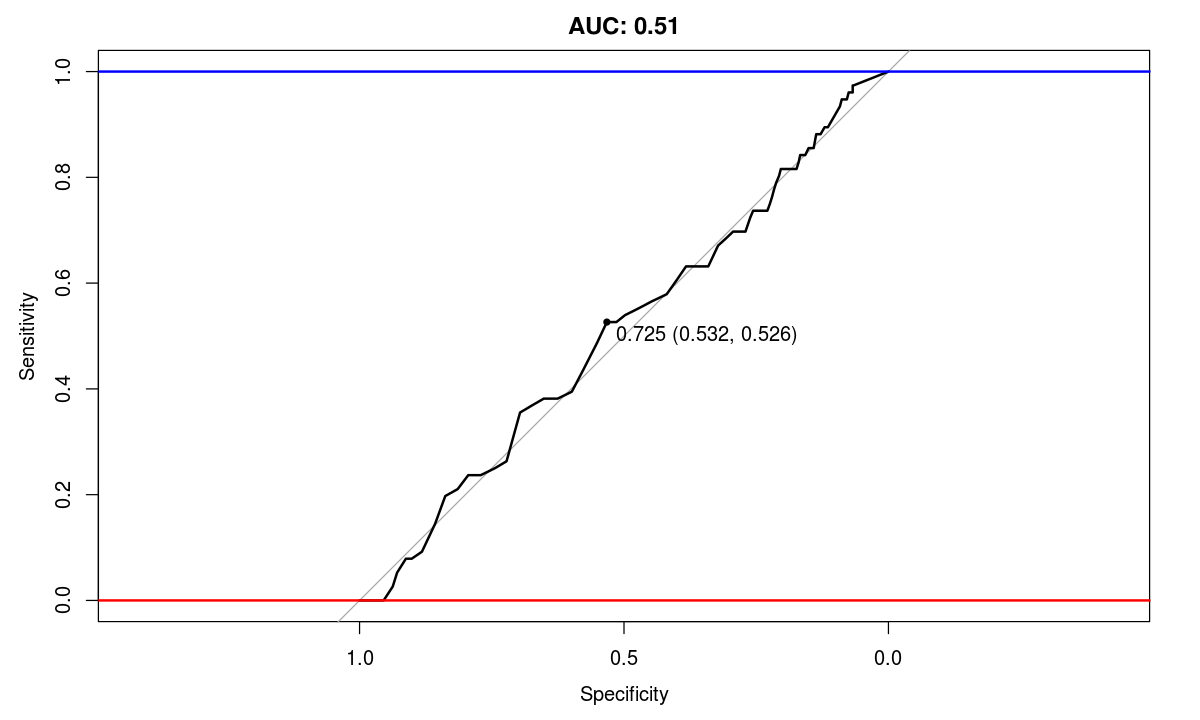

In [178]:
auc <- roc(imbal_test$Class, treebag_smote_pred$notDown)
plot(auc, ylim=c(0,1), print.thres=TRUE, main=paste('AUC:',round(auc$auc[[1]],2)))
abline(h=1,col='blue',lwd=2)
abline(h=0,col='red',lwd=2)

In [175]:
confusionMatrix(data = treebag_smote_pred$pred, reference = treebag_smote_pred$actual)

Warning message in confusionMatrix.default(data = treebag_smote_pred$pred, reference = treebag_smote_pred$actual):
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notDown down
   notDown     678   40
   down        772   36
                                          
               Accuracy : 0.4679          
                 95% CI : (0.4426, 0.4933)
    No Information Rate : 0.9502          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : -0.0106         
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.46759         
            Specificity : 0.47368         
         Pos Pred Value : 0.94429         
         Neg Pred Value : 0.04455         
             Prevalence : 0.95020         
         Detection Rate : 0.44430         
   Detection Prevalence : 0.47051         
      Balanced Accuracy : 0.47064         
                                          
       'Positive' Class : notDown         
                                          

### Support Vector Machine

In [40]:
set.seed(1234)
svm_fit <- train(Class ~ ., 
                 data = imbal_train, 
                 method = "svmRadial", 
                 trControl = fit_ctrl, 
                 preProc = c("center", "scale"),
                 #tuneLength = 8,
                 metric = "ROC", 
                 na.action = na.exclude)

In [41]:
svm_fit

Support Vector Machines with Radial Basis Function Kernel 

5789 samples
 168 predictor
   2 classes: 'notDown', 'down' 

Pre-processing: centered (168), scaled (168) 
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 5211, 5209, 5211, 5210, 5210, 5210, ... 
Resampling results across tuning parameters:

  C     ROC        Sens       Spec
  0.25  0.5802250  0.9999284  0   
  0.50  0.5801383  0.9999284  0   
  1.00  0.5801151  0.9998926  0   

Tuning parameter 'sigma' was held constant at a value of 0.009239124
ROC was used to select the optimal model using  the largest value.
The final values used for the model were sigma = 0.009239124 and C = 0.25. 

In [73]:
# show which variables are important in this model
varImp(svm_fit)

ROC curve variable importance

  only 20 most important variables shown (out of 168)

                    Importance
Valve5_mean             100.00
Valve3_mean              97.66
Valve5_min               97.54
Valve4_mean              95.37
Valve3_min               94.14
Valve2_mean              94.05
Valve4_min               93.28
Valve2_min               93.07
HMISpeed_min             88.38
Speed_min                88.05
ExitCnvySpeed_min        81.35
FolderSpeed_min          81.32
FeedConvySpeed_min       80.51
LowerCnvySpeed_min       80.41
EntrySpeed_min           79.75
MiddleCnvySpeed_min      79.61
FolderSpeed_mean         74.58
ExitCnvySpeed_mean       73.95
LowerCnvySpeed_mean      73.60
FeedConvySpeed_mean      73.02

In [42]:
svm_pred <- predict(svm_fit, imbal_test, type = "prob")
svm_pred$pred <- factor(ifelse(svm_pred$notDown >= .5, "notDown", "down"))
svm_pred <- cbind(svm_pred, actual = imbal_test$Class)

In [43]:
confusionMatrix(data = svm_pred$pred, reference = svm_pred$actual)

Warning message in confusionMatrix.default(data = svm_pred$pred, reference = svm_pred$actual):
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notDown down
   notDown    1450   76
   down          0    0
                                          
               Accuracy : 0.9502          
                 95% CI : (0.9381, 0.9606)
    No Information Rate : 0.9502          
    P-Value [Acc > NIR] : 0.5305          
                                          
                  Kappa : 0               
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 1.0000          
            Specificity : 0.0000          
         Pos Pred Value : 0.9502          
         Neg Pred Value :    NaN          
             Prevalence : 0.9502          
         Detection Rate : 0.9502          
   Detection Prevalence : 1.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positive' Class : notDown         
                                          

### AdaBoost Classification Trees

In [ ]:
set.seed(1234)
ada_fit <- train(Class ~ ., 
                 data = imbal_train, 
                 method = "adaboost",
                 trControl = fit_ctrl, 
                 na.action = na.exclude)

Warning message in train.default(x, y, weights = w, ...):
“The metric "Accuracy" was not in the result set. ROC will be used instead.”

In [ ]:
ada_fit

In [ ]:
ada_pred <- predict(ada_fit, imbal_test, type = "prob")
ada_pred$pred <- factor(ifelse(ada_pred$notDown >= .5, "notDown", "down"))
ada_pred <- cbind(ada_pred, actual = imbal_test$Class)

In [ ]:
confusionMatrix(data = ada_pred$pred, reference = ada_pred$actual)

### Neural Network

In [44]:
set.seed(1234)
net_fit <- train(Class ~ ., 
                 data = imbal_train, 
                 method = "avNNet",
                 na.action = na.exclude)

In [45]:
net_fit

Model Averaged Neural Network 

5789 samples
 168 predictor
   2 classes: 'notDown', 'down' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 5789, 5789, 5789, 5789, 5789, 5789, ... 
Resampling results across tuning parameters:

  size  decay  Accuracy   Kappa
  1     0e+00  0.9653251  0    
  1     1e-04  0.9653251  0    
  1     1e-01  0.9653251  0    
  3     0e+00  0.9653251  0    
  3     1e-04  0.9653251  0    
  3     1e-01  0.9653251  0    
  5     0e+00  0.9653251  0    
  5     1e-04  0.9653251  0    
  5     1e-01  0.9653251  0    

Tuning parameter 'bag' was held constant at a value of FALSE
Accuracy was used to select the optimal model using  the largest value.
The final values used for the model were size = 1, decay = 0.1 and bag = FALSE. 

In [76]:
# show which variables are important in this model
varImp(net_fit)

ROC curve variable importance

  only 20 most important variables shown (out of 168)

                    Importance
Valve5_mean             100.00
Valve3_mean              97.66
Valve5_min               97.54
Valve4_mean              95.37
Valve3_min               94.14
Valve2_mean              94.05
Valve4_min               93.28
Valve2_min               93.07
HMISpeed_min             88.38
Speed_min                88.05
ExitCnvySpeed_min        81.35
FolderSpeed_min          81.32
FeedConvySpeed_min       80.51
LowerCnvySpeed_min       80.41
EntrySpeed_min           79.75
MiddleCnvySpeed_min      79.61
FolderSpeed_mean         74.58
ExitCnvySpeed_mean       73.95
LowerCnvySpeed_mean      73.60
FeedConvySpeed_mean      73.02

In [46]:
net_pred <- predict(net_fit, imbal_test, type = "prob")
net_pred$pred <- factor(ifelse(net_pred$notDown >= .5, "notDown", "down"))
net_pred <- cbind(net_pred, actual = imbal_test$Class)

In [47]:
confusionMatrix(data = net_pred$pred, reference = net_pred$actual)

Warning message in confusionMatrix.default(data = net_pred$pred, reference = net_pred$actual):
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notDown down
   notDown    1450   76
   down          0    0
                                          
               Accuracy : 0.9502          
                 95% CI : (0.9381, 0.9606)
    No Information Rate : 0.9502          
    P-Value [Acc > NIR] : 0.5305          
                                          
                  Kappa : 0               
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 1.0000          
            Specificity : 0.0000          
         Pos Pred Value : 0.9502          
         Neg Pred Value :    NaN          
             Prevalence : 0.9502          
         Detection Rate : 0.9502          
   Detection Prevalence : 1.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positive' Class : notDown         
                                          

### Cost Sensitive Learning

In [48]:
stats <- function (data, lev = NULL, model = NULL)  {
  c(postResample(data[, "pred"], data[, "obs"]),
    Sens = sensitivity(data[, "pred"], data[, "obs"]),
    Spec = specificity(data[, "pred"], data[, "obs"]))
}

ctrl <- trainControl(method = "repeatedcv", 
                     repeats = 5,
                     summaryFunction = stats)

In [50]:
set.seed(1234)
c50_fit <- train(Class ~ ., 
                 data = imbal_train, 
                 method = "C5.0Cost",
                 tuneGrid = expand.grid(model = "tree", 
                                        winnow = c(TRUE, FALSE),
                                        trials = c(1:10),
                                        cost = 1:10),
                 metric = "Kappa",
                 trControl = ctrl, 
                 na.action = na.exclude)

In [51]:
c50_fit

Cost-Sensitive C5.0 

5789 samples
 168 predictor
   2 classes: 'notDown', 'down' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 5211, 5209, 5211, 5210, 5210, 5210, ... 
Resampling results across tuning parameters:

  winnow  cost  trials  Accuracy  Kappa  Sens  Spec
  FALSE    1     1      0.964934  0      1     0   
  FALSE    1     2      0.964934  0      1     0   
  FALSE    1     3      0.964934  0      1     0   
  FALSE    1     4      0.964934  0      1     0   
  FALSE    1     5      0.964934  0      1     0   
  FALSE    1     6      0.964934  0      1     0   
  FALSE    1     7      0.964934  0      1     0   
  FALSE    1     8      0.964934  0      1     0   
  FALSE    1     9      0.964934  0      1     0   
  FALSE    1    10      0.964934  0      1     0   
  FALSE    2     1      0.964934  0      1     0   
  FALSE    2     2      0.964934  0      1     0   
  FALSE    2     3      0.964934  0      1     0   
 

In [52]:
c50_pred <- predict(c50_fit, imbal_test)
c50_pred <- data.frame(predicted = c50_pred, actual = imbal_test$Class)

In [53]:
confusionMatrix(data = c50_pred$predicted, reference = c50_pred$actual)

Confusion Matrix and Statistics

          Reference
Prediction notDown down
   notDown    1450   76
   down          0    0
                                          
               Accuracy : 0.9502          
                 95% CI : (0.9381, 0.9606)
    No Information Rate : 0.9502          
    P-Value [Acc > NIR] : 0.5305          
                                          
                  Kappa : 0               
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 1.0000          
            Specificity : 0.0000          
         Pos Pred Value : 0.9502          
         Neg Pred Value :    NaN          
             Prevalence : 0.9502          
         Detection Rate : 0.9502          
   Detection Prevalence : 1.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positive' Class : notDown         
                                          

### RPART with Cost

In [54]:
cctrl1 <- trainControl(method = "cv", 
                       number = 3, 
                       returnResamp = "all")

cctrl2 <- trainControl(method = "LOOCV")

cctrl3 <- trainControl(method = "none")

cctrlR <- trainControl(method = "cv", 
                       number = 3, 
                       returnResamp = "all", 
                       search = "random")

In [55]:
set.seed(1234)
rpartC_fit <- train(Class ~ ., 
                    data = imbal_train, 
                    method = "rpartCost", 
                    trControl = cctrl2,
                    preProc = c("center", "scale"), 
                    metric = "Kappa",
                    na.action = na.exclude)

In [56]:
rpartC_fit

Cost-Sensitive CART 

5789 samples
 168 predictor
   2 classes: 'notDown', 'down' 

Pre-processing: centered (168), scaled (168) 
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 5788, 5788, 5788, 5788, 5788, 5788, ... 
Resampling results across tuning parameters:

  cp            Cost  Accuracy   Kappa       
  0.0006157635  3     0.9649335   0.000000000
  0.0008210181  2     0.9644153  -0.001022399
  0.0009852217  1     0.9632061   0.022388101

Kappa was used to select the optimal model using  the largest value.
The final values used for the model were cp = 0.0009852217 and Cost = 1. 

In [57]:
rpartC_pred <- predict(rpartC_fit, imbal_test)
rpartC_pred <- data.frame(predicted = rpartC_pred, actual = imbal_test$Class)

In [58]:
confusionMatrix(data = rpartC_pred$predicted, reference = rpartC_pred$actual)

Confusion Matrix and Statistics

          Reference
Prediction notDown down
   notDown    1450   76
   down          0    0
                                          
               Accuracy : 0.9502          
                 95% CI : (0.9381, 0.9606)
    No Information Rate : 0.9502          
    P-Value [Acc > NIR] : 0.5305          
                                          
                  Kappa : 0               
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 1.0000          
            Specificity : 0.0000          
         Pos Pred Value : 0.9502          
         Neg Pred Value :    NaN          
             Prevalence : 0.9502          
         Detection Rate : 0.9502          
   Detection Prevalence : 1.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positive' Class : notDown         
                                          

In [103]:
rpart_imp <- varImp(rpart_fit)$importance
rpart_imp <- rpart_imp[order(-), ]

,Overall
CircFanAct6_min,52.71660
ExitCnvySpeed_min,50.36131
FeedCnvyRatio_std,15.02560
FolderSpeed_min,50.36131
Hour,25.00330
LowerCnvySpeed_min,50.36131
MiddleCnvyRatio_std,44.64438
MiddleCnvySpeed_min,50.36131
Plevia_max,19.68849
Plevia_std,18.52597
